In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.gridspec as gridspec

In [2]:
# Number of sets
sets = 8

In [3]:
path = os.getcwd()

In [4]:
eac = pd.DataFrame()

for i in range(sets):
    path_file = os.path.join(path, f'Set{i+1}\\src\\eac_df_sparseness.xlsx')
    eacfile = pd.read_excel(path_file, index_col = [0])
    eac = pd.concat([eac, eacfile])

In [5]:
eac = eac.reset_index(drop = True)

In [6]:
eac 

,0.80,0.60,0.40,0.20,0.01
0,3.753057,5.889952,5.761413,5.451772,11.587235
1,4.021469,4.013558,4.156020,5.902424,5.123656
2,5.306106,4.365374,3.892503,5.958926,7.950613
3,4.226456,4.933437,4.242851,4.737318,6.096158
4,3.547054,3.520387,6.557902,4.468454,8.104171
...,...,...,...,...,...
395,3.398608,2.961866,5.457564,5.842286,3.542174
396,3.610827,2.884281,4.107760,6.824483,4.749368
397,4.987721,4.599037,4.915578,4.356315,7.884659
398,3.364988,4.419403,6.018398,6.504907,5.922948


In [7]:
# Adding one more column of sparsness 1 = 3,52518800553616
eai_spar1 = 3.52518800553616
eac[1] = eai_spar1

In [8]:
eac = eac[[1.00, 0.80, 0.60, 0.40, 0.20, 0.01]]

In [9]:
def plot_uncertainty_ax(df, ax):
    x = df.columns.astype(float)
    #percentiles = np.arange(40, 0, -15) 
    percentiles = [40, 25, 5]
    n = len(percentiles)
    alphas = np.linspace(0.5, 0.1, n)
    median = df.median(axis=0)
    
    ax.plot(x, median, color='black', linestyle = '--', 
             marker = 'o', markersize = 5, linewidth=1.5, label='Median')
    
    # Plot fading bands using red with varying alpha
    base_color = 'grey'
    for i, p in enumerate(percentiles):
        lower = df.quantile(p / 100, axis=0)
        upper = df.quantile(1 - p / 100, axis=0)
        
        # Alpha increases toward the center
        alpha = alphas[i]
        ax.fill_between(x, lower, upper, color=base_color, alpha=alpha, label = f"{p}$^{{th}}$ to {100 - p}$^{{th}}$ percentile")
    
    # Labels and title
    ax.set_xlabel("Dispersion parameter", fontname='Calibri', fontsize=10)
    ax.set_ylabel("EAI (in million €)", fontname='Calibri', fontsize=10)
    ax.set_xlim([0.2,1])
    ax.set_ylim([2, 25])
    ax.set_xticks([0.01, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xticklabels(['0' , '0.2', '0.4', '0.6', '0.8', '1'] , fontname='Calibri', fontsize=10)
    yticks = np.arange(0, 30, 5)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontname='Calibri', fontsize=10)
    ax.legend(frameon= False, prop={'family': 'Calibri', 'size': 10})
    ax.grid(True, linestyle='--', linewidth=0.5)

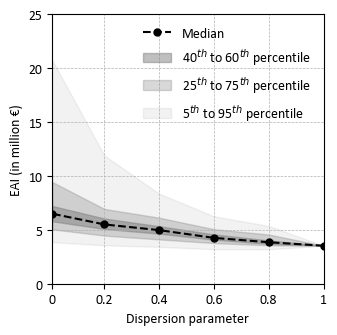

In [10]:
fig = plt.figure(figsize=(3.5, 3.5))
gs = gridspec.GridSpec(1, 1, height_ratios=[1], figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
plot_uncertainty_ax(eac, ax0)

In [11]:
df_stats = pd.read_parquet('df_stats.parquet')

In [12]:
sectors = gpd.read_parquet('industrial.parquet')
osmsites = gpd.read_parquet('is_nl33.parquet')

In [13]:
def firm_stat_calc_spar1(RP, spar, nos, set_no, sectors, osmsites, eac):
    path = os.path.join(os.getcwd(), f'spar_1\\osm_industrial_1.01_0.25_mosek_{RP}_{spar}_{nos}.xlsx')
    osm_df = pd.read_excel(path)

    sectors = sectors.to_crs(28992)
    osmsites = osmsites.to_crs(28992)

    osmsites['area'] = osmsites.area
    osmsites['flood_fail'] = osm_df['flood_fail']
    osmsites['power_fail'] = osm_df['power_fail']
    
    sectors_centroids = sectors.copy()
    sectors_centroids['geometry'] = sectors_centroids.geometry.centroid
    
    sectors_in_osmsite = gpd.sjoin(sectors_centroids, osmsites[['geometry', 'osmid', 'flood_fail', 'power_fail', 'area']],how='inner',predicate='within')
    # Only power failed
    sectors_pf = sectors_in_osmsite[sectors_in_osmsite['power_fail'] == 0]
    number_pf  = len(sectors_pf)
    flood_and_power =sectors_in_osmsite[(sectors_in_osmsite['power_fail'] == 0) & (sectors_in_osmsite['flood_fail'] == 0)]
    number_fandp  = len(flood_and_power)
    a = [RP ,spar, nos, set_no, number_pf, number_fandp, eac]
    return a

In [14]:
a = firm_stat_calc_spar1(1000, 1, 0, 1, sectors, osmsites, eai_spar1)
b = firm_stat_calc_spar1(10000, 1, 0, 1, sectors, osmsites, eai_spar1)

In [15]:
df_stats

,RP,spar,nos,set_no,number_pf,number_fandp,eai
0,1000,0.01,0,1,143,18,11.587235
1,1000,0.01,1,1,44,0,5.123656
2,1000,0.01,2,1,88,0,7.950613
3,1000,0.01,3,1,54,12,6.096158
4,1000,0.01,4,1,58,22,8.104171
...,...,...,...,...,...,...,...
3995,10000,0.80,45,8,305,136,3.398608
3996,10000,0.80,46,8,279,144,3.610827
3997,10000,0.80,47,8,272,141,4.987721
3998,10000,0.80,48,8,253,117,3.364988


In [16]:
df_stats.loc[len(df_stats)] = a
df_stats.loc[len(df_stats)] = b
df_stats['ponly'] = df_stats['number_pf'] - df_stats['number_fandp']

In [17]:
rp1000 = df_stats[df_stats['RP'] == 1000].reset_index(drop = True)
rp10000 = df_stats[df_stats['RP'] == 10000].reset_index(drop = True)

In [18]:
df_rp = pd.DataFrame(columns = ['spar','p_1000', 'p_10000', 'pf_1000', 'pf_10000', 'eai'])

In [19]:
for i in range(len(rp10000)):
    df_rp.loc[i, 'eai'] = rp10000.loc[i,'eai']
    df_rp.loc[i, 'p_1000'] = rp1000.loc[i,'number_pf']
    df_rp.loc[i, 'p_10000'] = rp10000.loc[i,'number_pf']
    df_rp.loc[i, 'pf_1000'] = rp1000.loc[i,'number_fandp']
    df_rp.loc[i, 'pf_10000'] = rp10000.loc[i,'number_fandp']
    df_rp.loc[i, 'spar'] = rp10000.loc[i,'spar']

In [20]:
df_rp['psum'] = 10*df_rp['p_1000'] + df_rp['p_10000']
df_rp['pfsum'] = 10*df_rp['pf_1000'] + df_rp['pf_10000']

In [21]:
#df_rp = df_rp[df_rp['spar'] != 0.01].reset_index(drop = True)

In [22]:
df_rp['ponly'] = df_rp['psum'] - df_rp['pfsum']

In [23]:
def plot_uncertainty_from_df_dual(df, ax, col1, col2, label1, label2, c1, c2):
                                 
    percentiles = [40, 25, 5]
    n = len(percentiles)
    alphas = np.linspace(0.5, 0.1, n)
    base_color = 'grey'

    # Ensure spar is sorted
    spar_values = sorted(df['spar'].unique())
    df[col1] = pd.to_numeric(df[col1], errors='coerce')
    df[col2] = pd.to_numeric(df[col2], errors='coerce')

    # Prepare secondary axis
    ax2 = ax.twinx()

    # --- For col1 (Left Y-axis, Blue Line) ---
    median1 = df.groupby('spar')[col1].median()
    quantiles1 = {
        p: df.groupby('spar')[col1].quantile([p / 100, 1 - p / 100]).unstack()
        for p in percentiles
    }
    x = np.array(spar_values, dtype=float)
    y1 = median1.loc[spar_values].values
    ax.plot(x, y1, color=c1, linestyle='--', marker='o',
            markersize=5, linewidth=1.5, label=f'{label1} Median')

    for i, p in enumerate(percentiles):
        lower = quantiles1[p].loc[spar_values][p / 100].values
        upper = quantiles1[p].loc[spar_values][1 - p / 100].values
        ax.fill_between(x, lower, upper, color=base_color, alpha=alphas[i])

    # --- For col2 (Right Y-axis, Red Line) ---
    median2 = df.groupby('spar')[col2].median()
    quantiles2 = {
        p: df.groupby('spar')[col2].quantile([p / 100, 1 - p / 100]).unstack()
        for p in percentiles
    }
    y2 = median2.loc[spar_values].values
    ax2.plot(x, y2, color=c2, linestyle='--', marker='o',
             markersize=5, linewidth=1.5, label=f'{label2} Median')

    for i, p in enumerate(percentiles):
        lower = quantiles2[p].loc[spar_values][p / 100].values
        upper = quantiles2[p].loc[spar_values][1 - p / 100].values
        ax2.fill_between(x, lower, upper, color=base_color, alpha=alphas[i])

    # --- Axis Formatting ---
    ax.set_xlabel("Dispersion parameter", fontsize=10, fontname='Calibri')
    ax.set_ylabel(label1, fontsize=10, fontname='Calibri', color=c1)
    ax2.set_ylabel(label2, fontsize=10, fontname='Calibri', color=c2)

    ax.set_xlim([0.2, 1])
    ax.set_xticks([0.01, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'],fontname='Calibri', fontsize=10 )

    ax.set_ylim([0, 1800])
    ax2.set_ylim([0, 1800])
    yticks = np.arange(0, 2100, 300)

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontname='Calibri', fontsize=10, color=c1)

    ax2.set_yticks(yticks)
    ax2.set_yticklabels(yticks, fontname='Calibri', fontsize=10, color=c2)

    ax.grid(True, linestyle='--', linewidth=0.5)



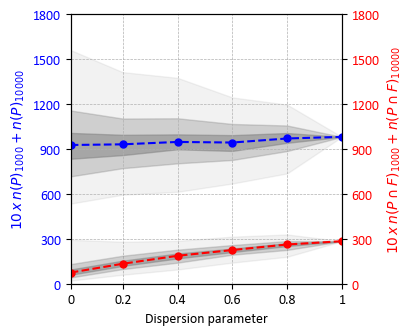

In [24]:
fig, (ax1) = plt.subplots(1, 1, figsize=(3.5, 3.5))
plot_uncertainty_from_df_dual(df_rp, ax1, 'psum', 'pfsum',r'$10\, x \, n(P)_{1000} + n(P)_{10000}$',r'$10 \, x \, n(P \cap F)_{1000} + n(P \cap F)_{10000}$','blue','red')

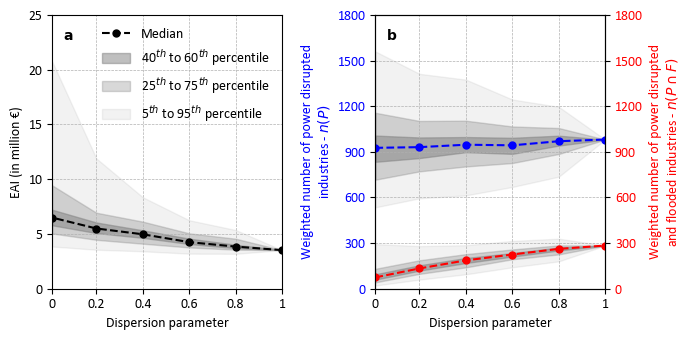

In [37]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 3.5))
plot_uncertainty_ax(eac, ax0)
#plot_uncertainty_from_df_dual(df_rp, ax1, 'psum', 'pfsum',r'$10\, x \, n(P)_{1000} + n(P)_{10000}$',r'$10 \, x \, n(P \cap F)_{1000} + n(P \cap F)_{10000}$','blue','red')
plot_uncertainty_from_df_dual(df_rp, ax1, 'psum', 'pfsum', r'Weighted number of power disrupted' + '\n' + r'industries - $\mathit{n (P)}$' ,r'Weighted number of power disrupted' + '\n' + \
        r'and flooded industries - $\mathit{n (P \cap F)}$'
,'blue','red')
ax0.text(0.05, 0.95, 'a', transform=ax0.transAxes, fontsize=10, verticalalignment='top', fontweight='bold')
ax1.text(0.05, 0.95, 'b', transform=ax1.transAxes, fontsize=10, verticalalignment='top', fontweight='bold')
plt.tight_layout()
plt.savefig('uncertainty_analysis.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [26]:
eac.quantile(0.95)

1.00     3.525188
0.80     5.362624
0.60     6.254407
0.40     8.355781
0.20    11.897704
0.01    20.739573
Name: 0.95, dtype: float64

In [27]:
eac.median()

1.00    3.525188
0.80    3.847192
0.60    4.252875
0.40    4.972378
0.20    5.500011
0.01    6.494346
dtype: float64

In [28]:
df_rp.groupby('spar')['pfsum'].median()

spar
0.01     74.5
0.20    133.5
0.40    186.5
0.60    225.0
0.80    262.0
1.00    284.0
Name: pfsum, dtype: float64

In [29]:
df_rp.groupby('spar')['psum'].median()

spar
0.01    926.5
0.20    931.0
0.40    947.0
0.60    943.0
0.80    970.0
1.00    981.0
Name: psum, dtype: float64